In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
import scipy.stats as stats
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits import mplot3d
from sklearn import metrics


from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_DIR = '/Users/andishetavakkoli/Documents/notebook/github_project/machine-learning-projects-data/'

In [5]:
df = pd.read_csv(DATA_DIR + 'housing.csv')

## Visualization

In [8]:
df_corr = df.corr() 

In [9]:
df_corr[(df_corr > 0.4) | (df_corr < -0.4)].columns.to_list()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [6]:
selected_fetures = ['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_house_value',
]

<Axes: >

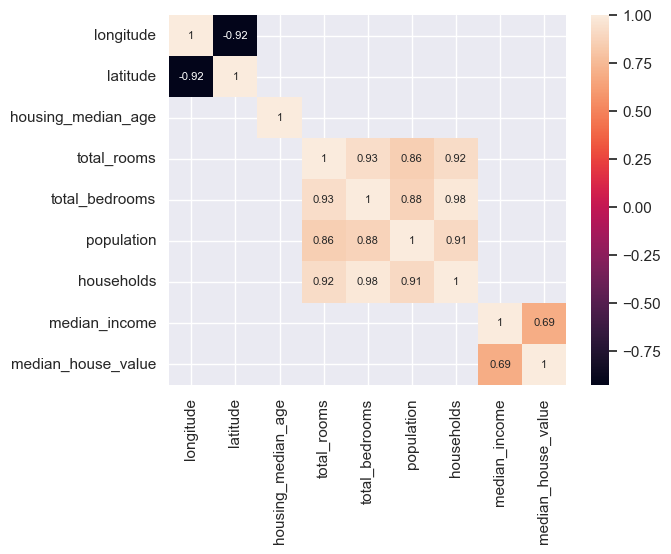

In [13]:
sns.heatmap(df_corr[(df_corr > 0.4) | (df_corr < -0.4)], annot=True, annot_kws={'fontsize': 8})

In [1]:
# sns.pairplot(df[selected_fetures])

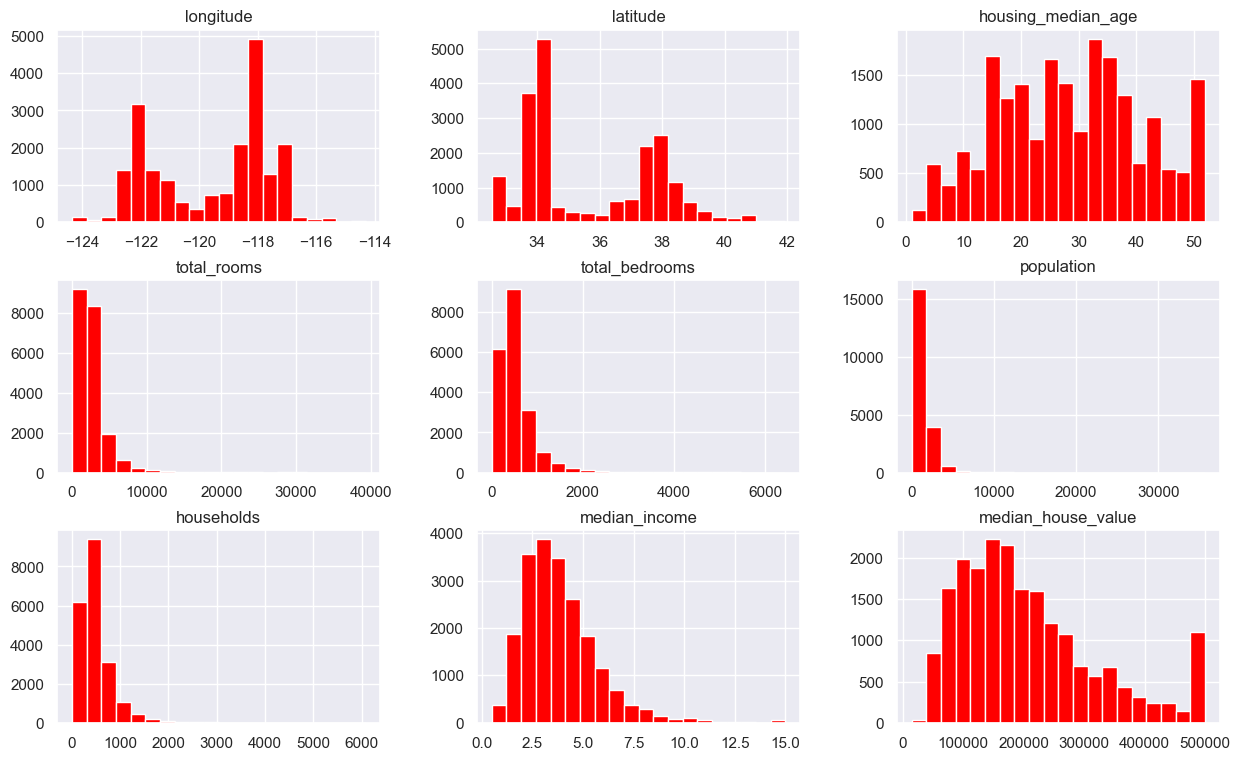

In [152]:
df.hist(figsize=(15,9), bins=20, color='red');

## Label Encoding

In [7]:
le = LabelEncoder()
df['ocean_proximity'] = le.fit_transform(df['ocean_proximity'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


In [8]:
df['ocean_proximity'].value_counts()

0    9136
1    6551
4    2658
3    2290
2       5
Name: ocean_proximity, dtype: int64

## Outlier Detection

In [16]:
from scipy.stats import zscore
df_z_score = df.apply(zscore)
df_z_score.columns =[col +'_zscore' for col in df_z_score.columns]

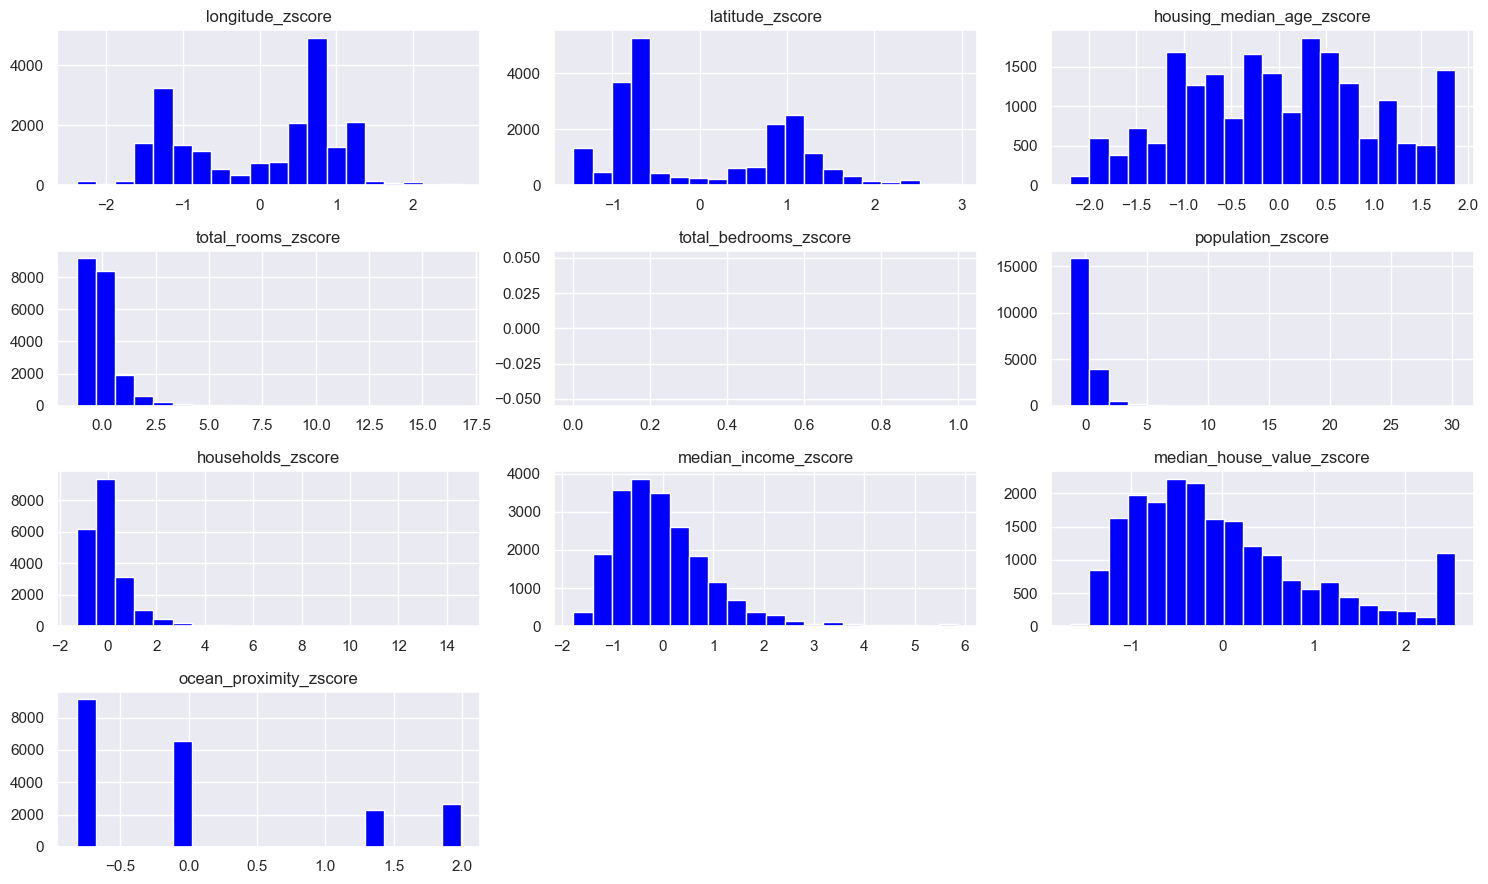

In [17]:
df_z_score.hist(figsize=(15,9), bins=20, color='blue')
plt.tight_layout();

In [18]:
def detect_anomalies_iqr(data, k=1.5):
    '''
    Detects anomalies in a 1D array of data using the IQR method.
    Returns a boolean array indicating which values are anomalies.
    
    Parameters:
        data (array-like): The input data to be analyzed.
        k (float): The multiplier for the IQR above which a value is
            considered an anomaly. Default is 1.5.
    
    Returns:
        A boolean array indicating which values are anomalies.
    '''
    quartile1, quartile3 = np.percentile(data, [0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - k * iqr
    upper_bound = quartile3 + k * iqr
    return (data < lower_bound) | (data > upper_bound)

In [19]:
detect_anomalies_iqr(df['households'], k=1.5).sum()

20347

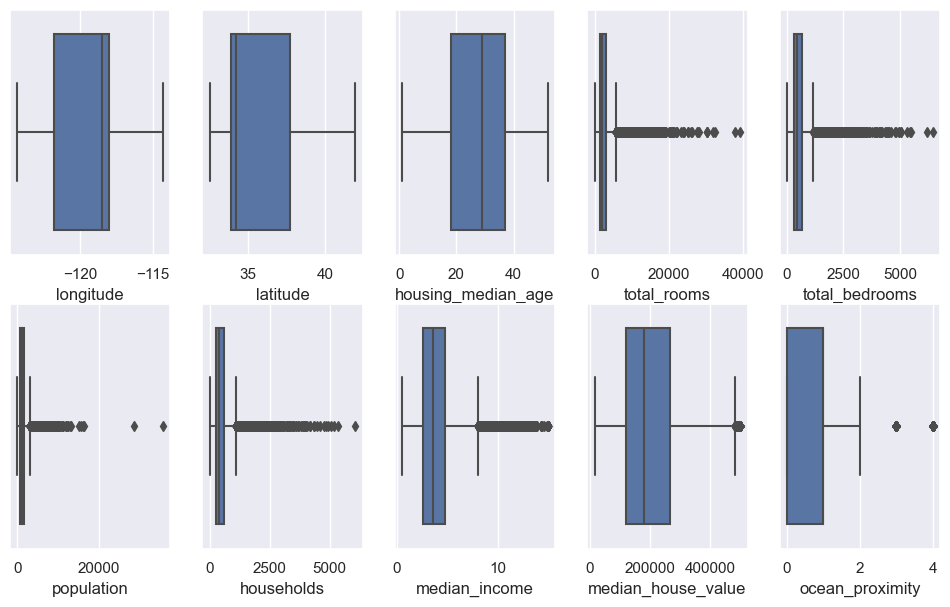

In [21]:
index = 0
plt.figure(figsize=(12,7))
for feature in df.columns:
    index += 1
    plt.subplot(2,5,index)
    sns.boxplot(x=feature, data=df, whis=1.5)

## Remove the Outlier

In [20]:
def remove_outlier(df, col, threshold=3):

    mean = np.mean(df[col])
    std = np.std(df[col])
    z_scores = (df[col] - mean) / std
    
    print(f'del {df[(z_scores > threshold)].shape[0]} row of data!')
    return df[~(np.abs(z_scores) > threshold)]

for col in df.columns:
    df= remove_outlier(df, col, threshold=3)    

del 0 row of data!
del 0 row of data!
del 0 row of data!
del 373 row of data!
del 362 row of data!
del 274 row of data!
del 214 row of data!
del 327 row of data!
del 0 row of data!
del 0 row of data!


In [21]:
 df.shape

(19090, 10)

In [23]:
'''This function detects the best z-score for outlier detection in the specified column.'''

def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.05, print_list = False):
    z_scores = stats.zscore(df[col].dropna())
    threshold_list = []
    
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
    
    df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
    df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    df_outlier['pct'] = df_outlier['pct'].apply(lambda x : x-100 if x == 100 else x)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    IQR_coef = round((best_treshold - 0.675) / 1.35, 2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    num_outlier = df_outlier.iloc[df_outlier.pct.argmax(), 1]
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), colors="r", ls = ":")
    plt.annotate("Zscore : {}\nIQR_coef : {}\nValue : {}\nNum_outlier : {}\nPercentile : {}".format(best_treshold,
                                                                          IQR_coef,
                                                                          outlier_limit,
                                                                          num_outlier,     
                                                                          (np.round(percentile_threshold, 3), 
                                                                           np.round(100-percentile_threshold, 3))),
                                                                          (best_treshold, df_outlier.outlier_count.max()/2))
    plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, IQR_coef, outlier_limit, num_outlier, percentile_threshold)

In [24]:
def outlier_inspect(df, col, min_z = 1, max_z = 5, step = 0.05, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.distplot(df[col], kde=False, bins = 50)
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z = min_z, max_z = max_z, step = step)
    plt.show()

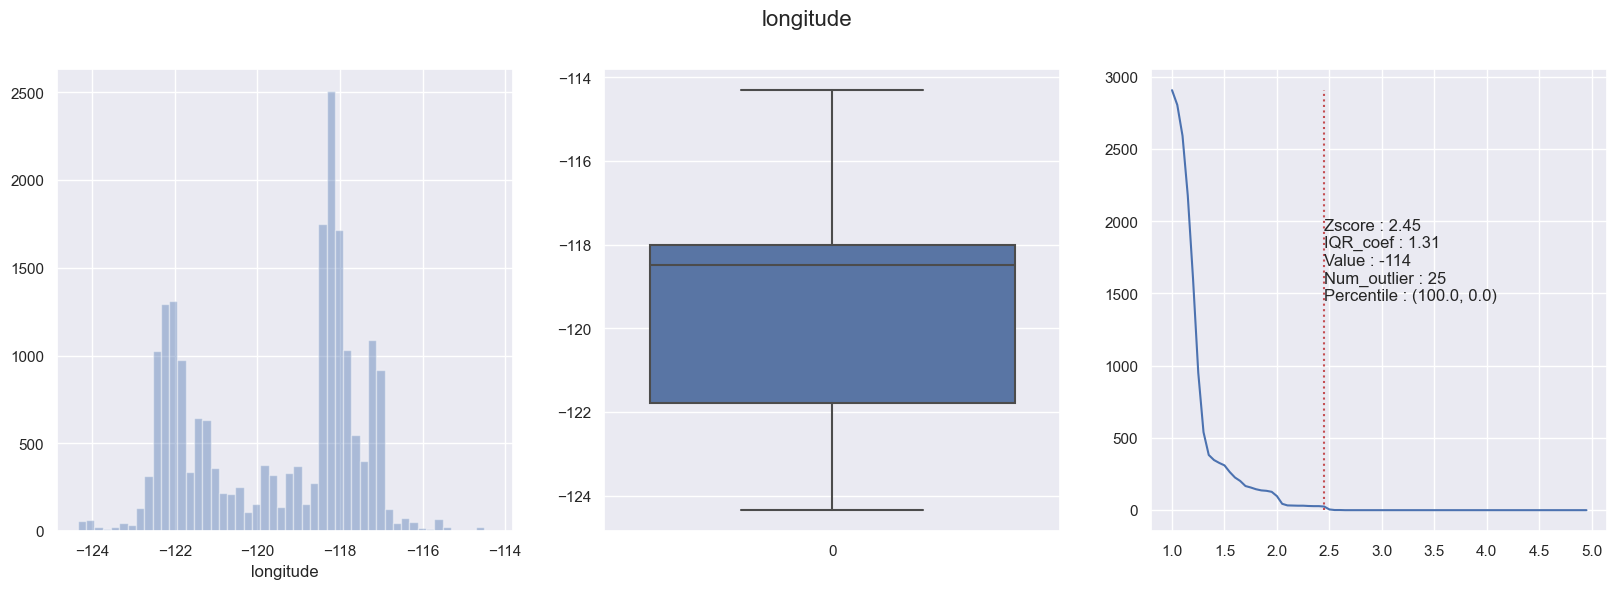

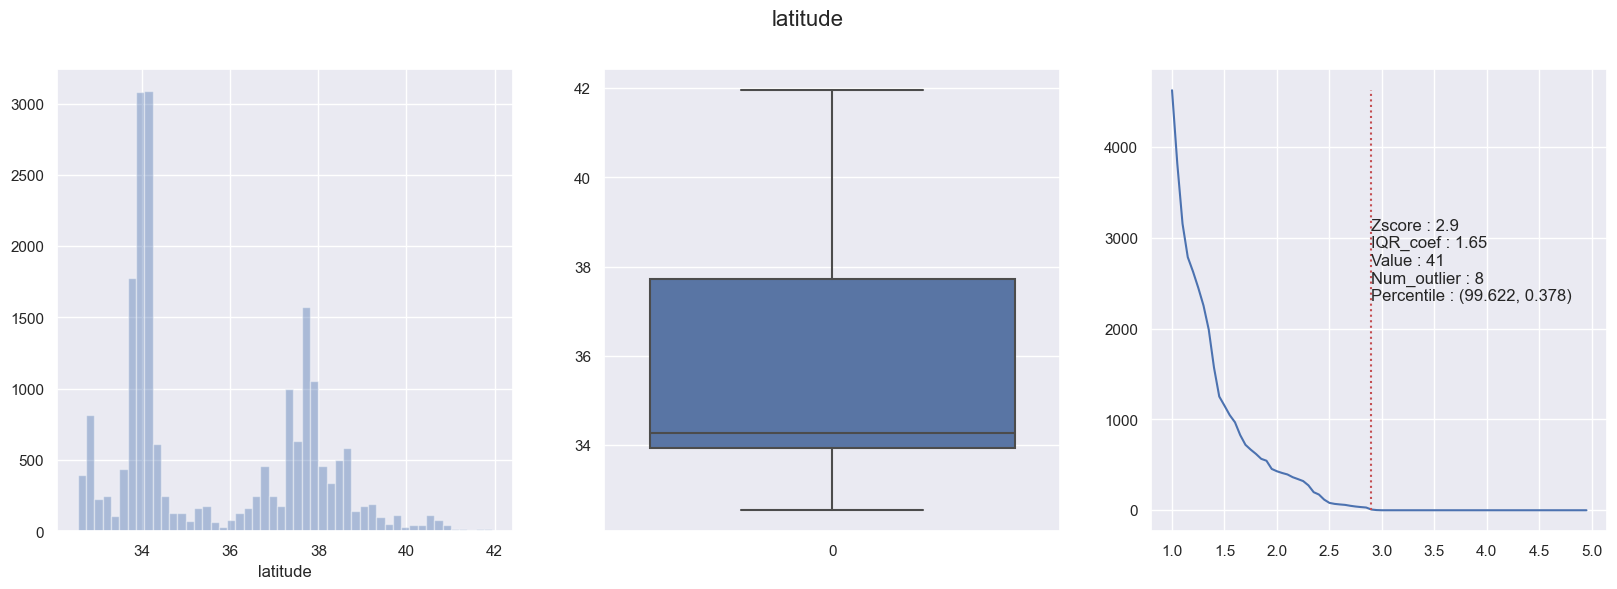

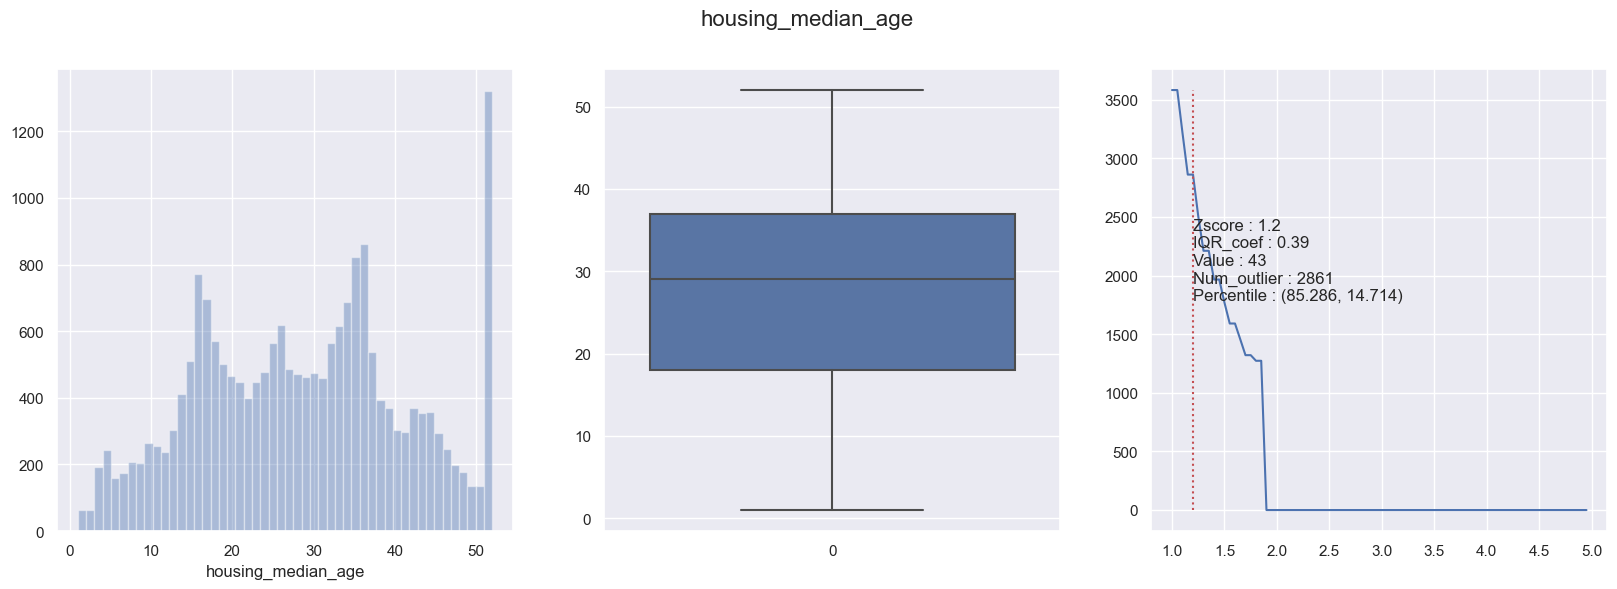

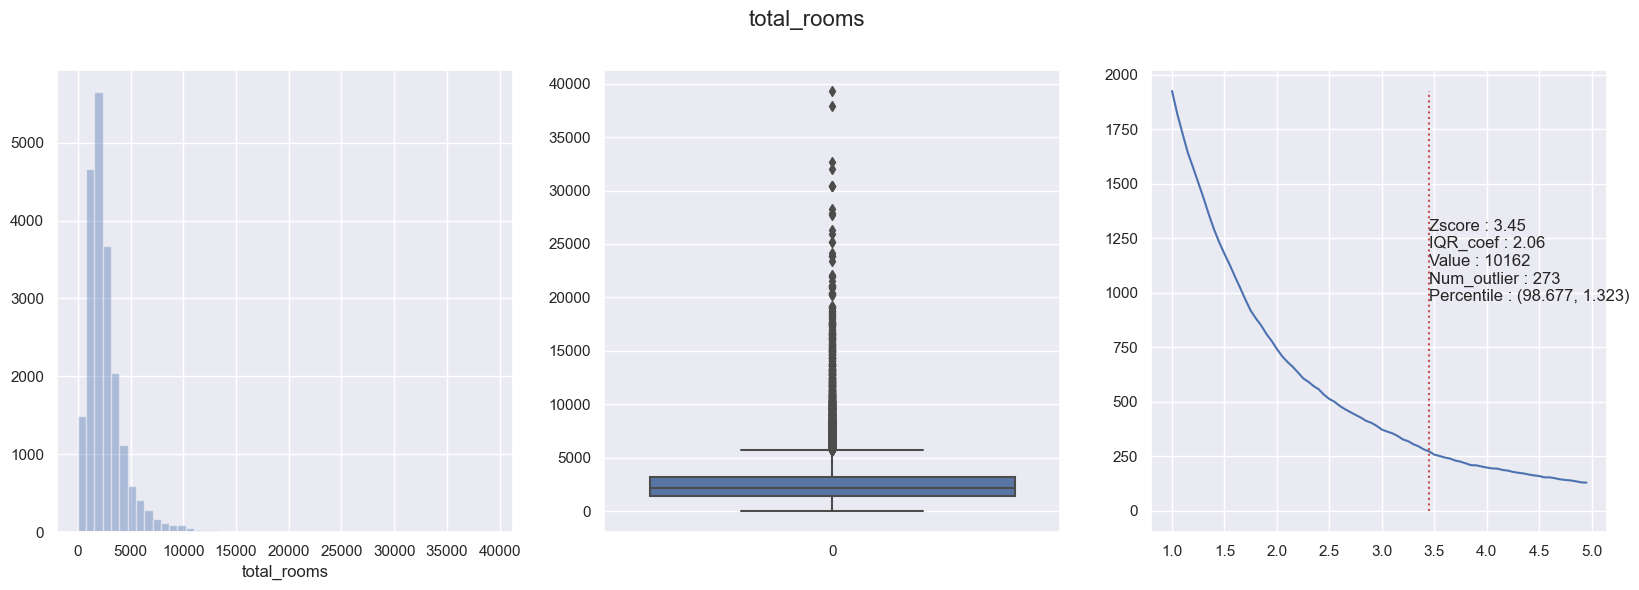

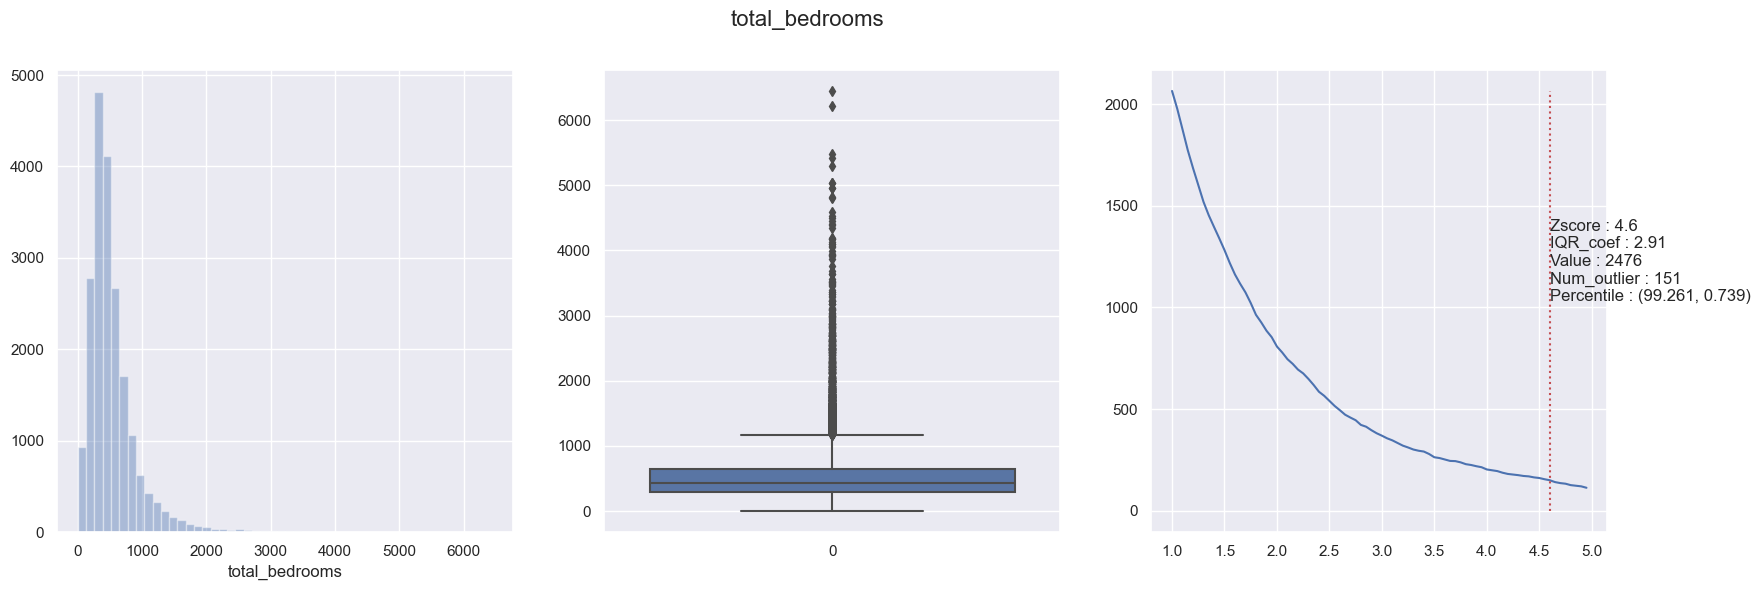

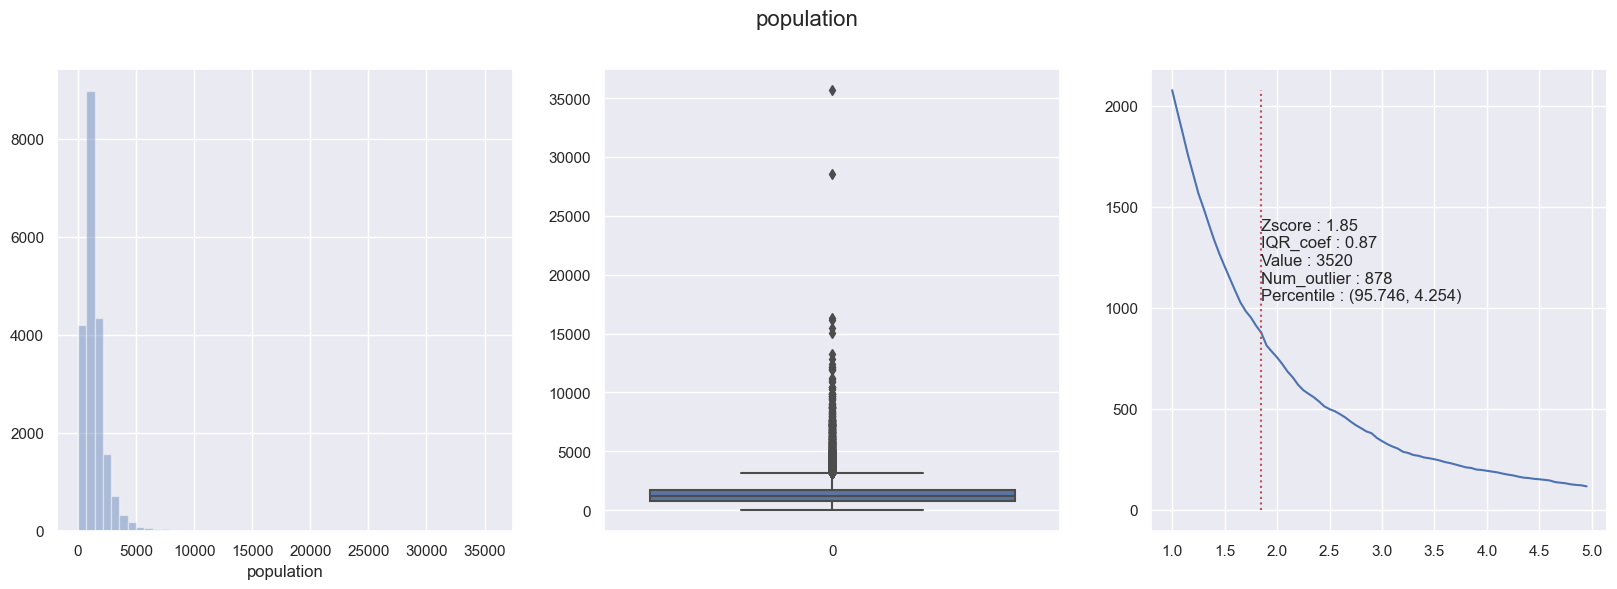

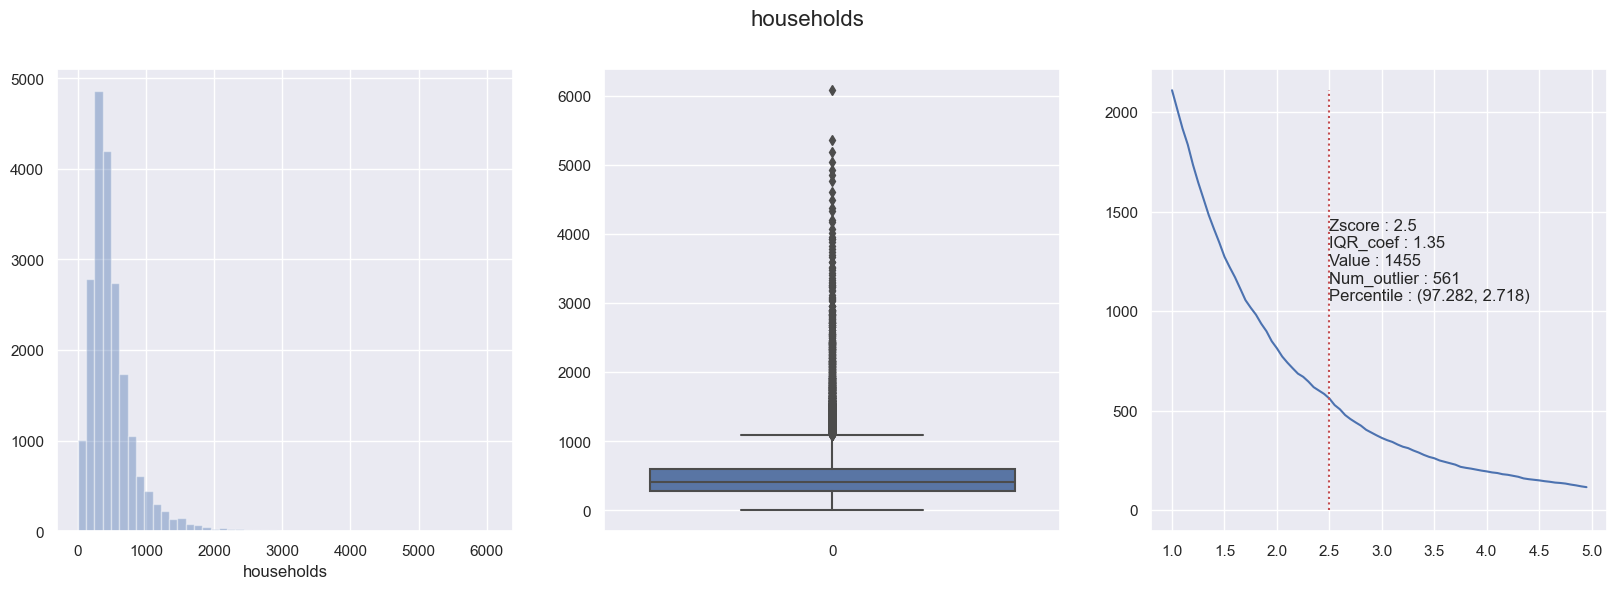

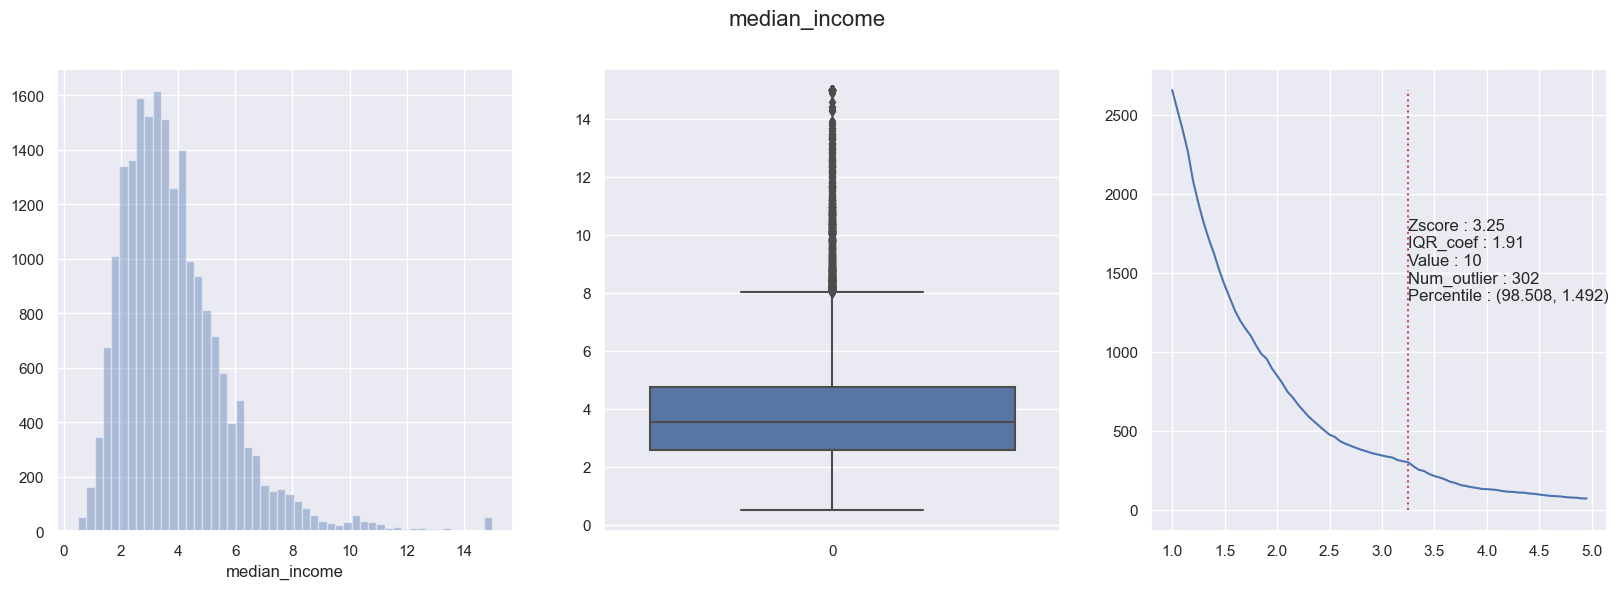

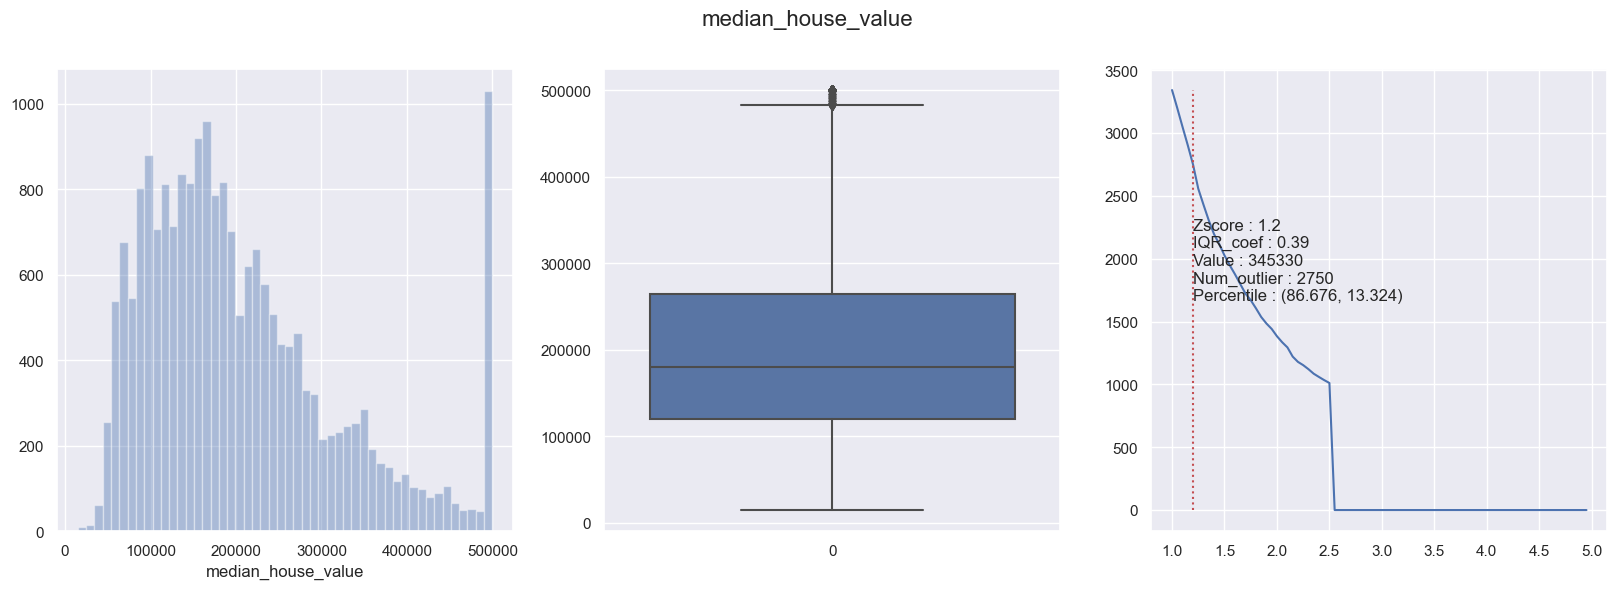

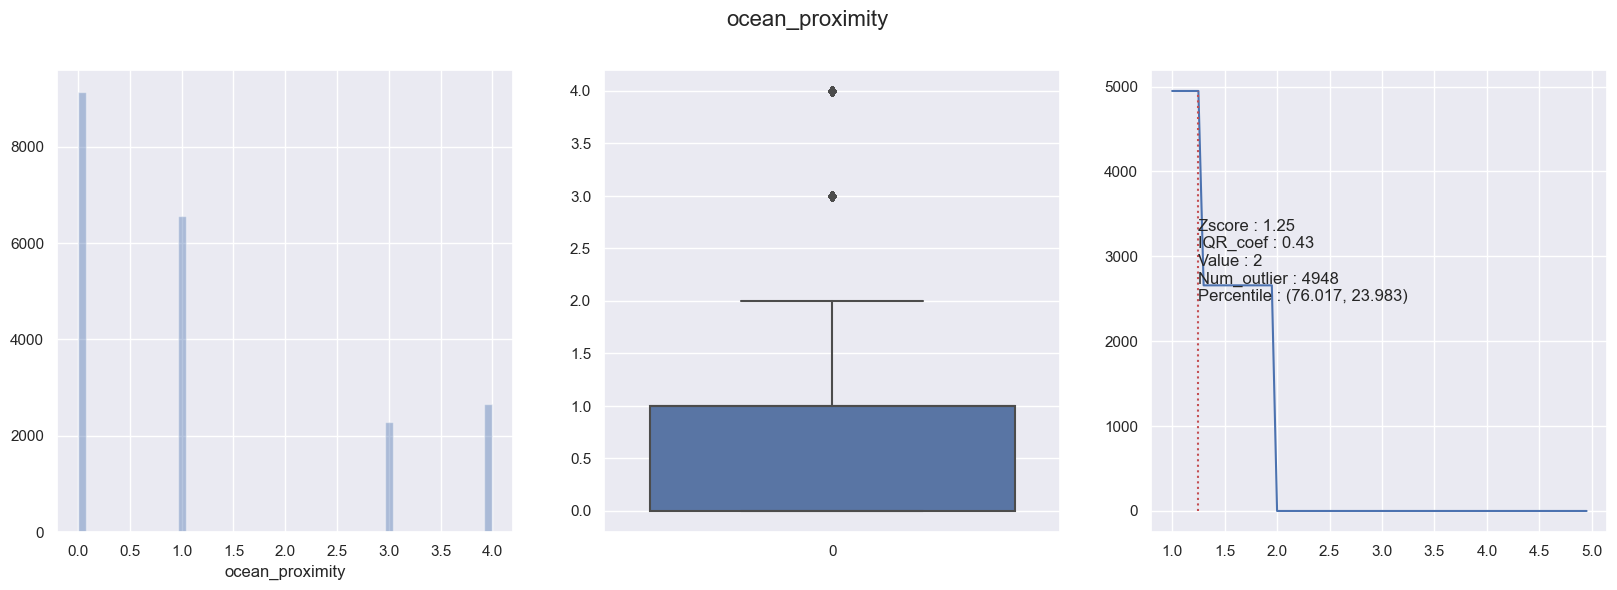

In [94]:
for col in df.columns:
    outlier_inspect(df, col, min_z = 1, max_z = 5, step = 0.05, max_hist = None, bins = 50)

## Scaling

In [9]:
scaler = StandardScaler()
df_scale = scaler.fit_transform(df)

## Handel Missing values

In [10]:
si = SimpleImputer(strategy='mean')
df_scale = si.fit_transform(df_scale)

In [11]:
np.isnan(df_scale).sum()

0

## KMeans Model

In [20]:

kmeans.labels_

array([3, 2, 3, ..., 0, 0, 0], dtype=int32)

In [25]:
for n in range(2,11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df_scale)
    silhouette_score = metrics.silhouette_score(df_scale, kmeans.labels_)
    print(f'for {n} clusters : silhouette_score is {silhouette_score}')

for 2: silhouette_score is 0.36674525316151163
for 3: silhouette_score is 0.2529498369749602
for 4: silhouette_score is 0.24532746386078882
for 5: silhouette_score is 0.24478461759789763
for 6: silhouette_score is 0.23588104598483556
for 7: silhouette_score is 0.25616122950030856
for 8: silhouette_score is 0.22571317874124858
for 9: silhouette_score is 0.22072696190610602
for 10: silhouette_score is 0.21266074258539652


## Build Pipeline

In [41]:
from sklearn.compose import ColumnTransformer

In [148]:
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())]
)

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())]
)

cat_features = df.select_dtypes(exclude='number').columns
num_features = df.select_dtypes(include='number').columns

ct = ColumnTransformer([
    ('cat_transformer', cat_transformer, cat_features),
    ('num_transformer', num_transformer, num_features)],
    remainder='passthrough'
)


df_clean = ct.fit_transform(df)


cluster_model = Pipeline([
    ('ct', ct),
    ('model', KMeans(n_clusters=8, random_state=42))
])

cluster_model.fit(df)
labels = cluster_model.named_steps['model'].labels_


In [149]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([1571, 6473, 1321, 2249, 2198,  503, 3300, 3025]))

In [150]:
df['cluster'] = labels

In [136]:
# sns.pairplot(df_clean, hue='cluster')

## Apply TSNE Function

In [151]:
def tsne(df, labels):
        
    tsne = TSNE()
    df_tsne = tsne.fit_transform(df)

    df_tsne = pd.DataFrame(df_tsne, columns=['x1', 'x2'])
    df_tsne['label'] = labels

    sns.scatterplot(df_tsne, x='x1', y='x2', hue='label', palette='tab10')
    plt.show()

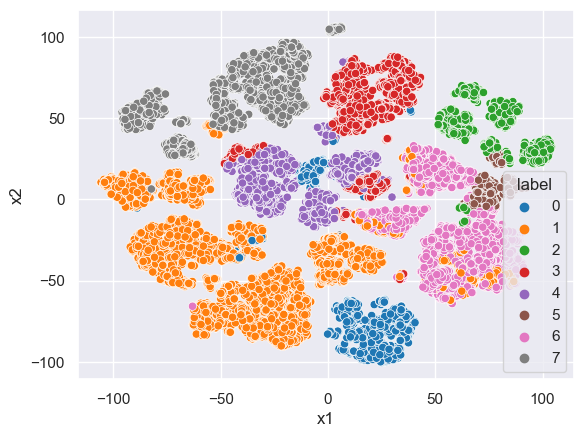

In [152]:
# No PCA
tsne(df_clean, labels)

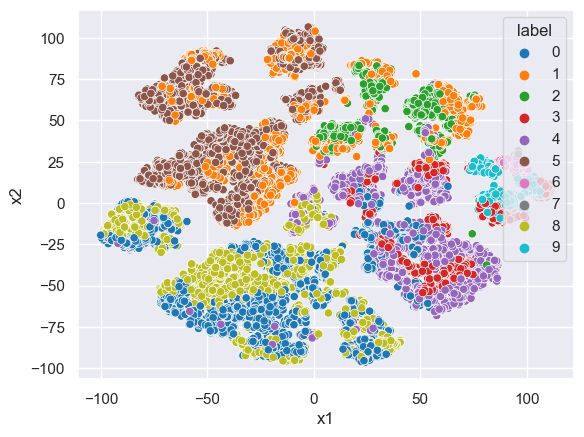

In [138]:
# With PCA
tsne(df_clean, labels)

In [ ]:
# Evaluation Model Performance

In [153]:
from sklearn import metrics

# labels_true = [0, 0, 1, 1, 2, 2]  # True labels
# labels_pred = [0, 0, 1, 1, 1, 2]  # Predicted labels

silhouette_score = metrics.silhouette_score(df_clean, labels)
# calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels_pred)
# davies_bouldin_score = metrics.davies_bouldin_score(data, labels_pred)
# adjusted_rand_index = metrics.adjusted_rand_score(labels_true, labels_pred)
# normalized_mutual_info = metrics.normalized_mutual_info_score(labels_true, labels_pred)
# homogeneity = metrics.homogeneity_score(labels_true, labels_pred)
# completeness = metrics.completeness_score(labels_true, labels_pred)
# v_measure = metrics.v_measure_score(labels_true, labels_pred)
# fowlkes_mallows = metrics.fowlkes_mallows_score(labels_true, labels_pred)

In [154]:
silhouette_score

0.2775717978685555

# Dimension Reduction

In [78]:
# Access the labels assigned by the KMeans model
labels = cluster_model.named_steps['model'].labels_

In [79]:
labels

array([0, 1, 0, ..., 3, 3, 3], dtype=int32)

### PCA

In [30]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scale)

In [31]:
df_pca[:,0]

array([-2.49673415,  5.81228046, -2.20461509, ..., -0.30452754,
       -0.99664246,  0.69610081])

<Axes: >

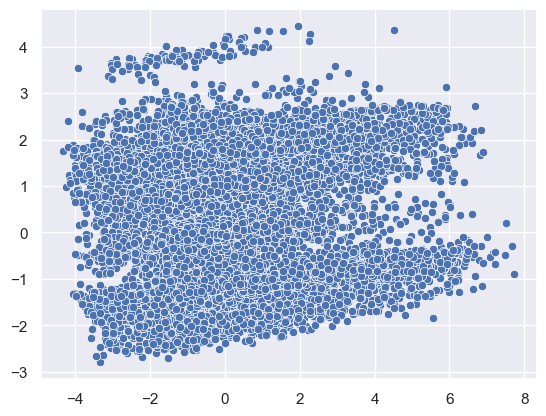

In [226]:
sns.scatterplot(df, x=df_pca[:,0], y=df_pca[:,1])

### TSNE

In [244]:

tsne = TSNE()
df_tsne = tsne.fit_transform(df_scale)
sns.scatterplot(df_tsne, x=df_tsne[:,0], y=df_tsne[:,1])

<Axes: >

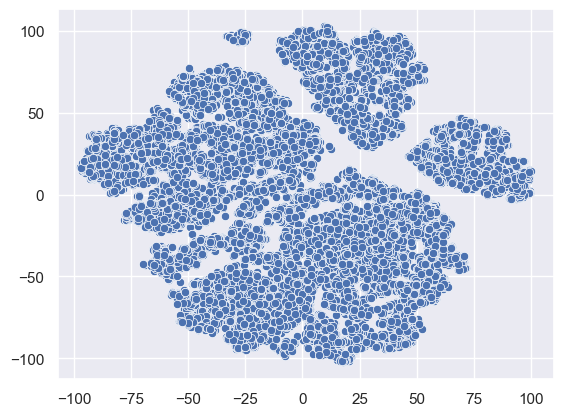

## 3d TSNE Plot

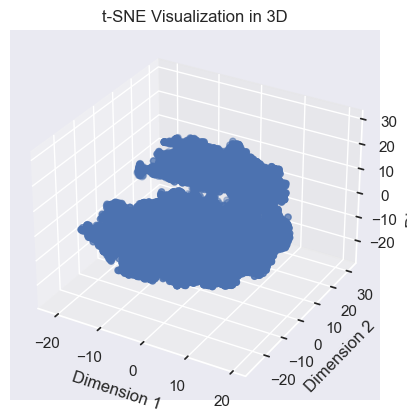

In [248]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE


# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(df_scale)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points in 3D
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], cmap='viridis')

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('t-SNE Visualization in 3D')

# Show the plot
plt.show()


## Draw Elbow

In [131]:
def create_elbow(df):
    df = pd.DataFrame(df)
    df.columns = df.columns.astype(str)
    k_dict = {}
    
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k).fit(df)
        df['kmeans_label'] = kmeans.labels_
        k_dict[k] = kmeans.inertia_
        
    sns.lineplot(x=k_dict.keys(), y=k_dict.values())
    plt.xlabel("Number of cluster")
    plt.ylabel("Inertia")
    plt.show()


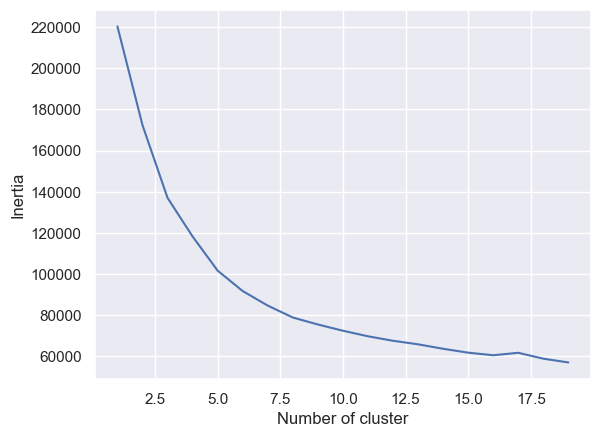

In [132]:
create_elbow(df_clean)

## Model: KMeans

array([1, 3, 1, ..., 5, 5, 5], dtype=int32)

In [260]:
# kmeans.cluster_centers_

In [293]:
df['labels'] = kmeans.labels_

In [294]:
df['labels'].value_counts()

5    4761
2    4312
4    2727
1    2710
0    2465
3    2115
Name: labels, dtype: int64

## Model: DBSCAN